In [52]:
!pip install texthero
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import texthero as hero

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv


In [53]:
## leitura
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

In [54]:
list(df.columns)

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

## Tratamento e EDA?

In [55]:
#queremos apenas as colunas summary, text e score
df = df[['Summary', 'Text', 'Score']]
df = df.rename(str.lower, axis='columns')
df.head()


,summary,text,score
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,5
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1
2,"""Delight"" says it all",This is a confection that has been around a fe...,4
3,Cough Medicine,If you are looking for the secret ingredient i...,2
4,Great taffy,Great taffy at a great price. There was a wid...,5


In [56]:
df['text'] = hero.clean(df['text'])


In [57]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

568454
394710


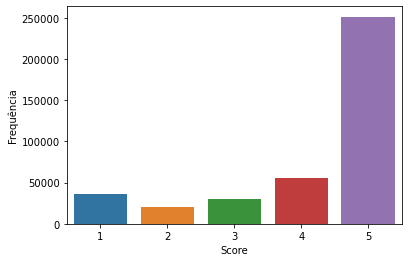

In [58]:
import seaborn as sns 
import matplotlib.pyplot as plt 

ax = sns.countplot(df['score']) 
ax.set(xlabel='Score', ylabel='Frequência')
plt.show()


 - dados desbalanceados

In [59]:
## fazer o split

In [60]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, teste_size = 0.2)

## Modelos

### Validação cruzada utilizando naive bayes multinomial para as 5 classes

In [61]:
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [62]:
teste = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer()),
                     ('MNB', MultinomialNB())])



In [63]:
from sklearn.model_selection import cross_validate
cv_pred = cross_validate(teste,
                             df['text'], 
                             df['score'], 
                             cv=5,
                             scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   37.0s remaining:   55.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   37.1s remaining:   24.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   57.2s finished


In [64]:
print('roc: ' + str(cv_pred['test_roc_auc_ovr']))
print('acuracia: ' + str(cv_pred['test_accuracy']))

roc: [0.76575797 0.76538489 0.76574188 0.77184195 0.76946176]
acuracia: [0.64323174 0.64296572 0.64349776 0.64338375 0.64357376]


### Tentativa com naive bayes considerando dados binarios 

In [65]:
tr_where = np.where(df.score <= 3, 0, 1)
#tst = pd.Series(tr_where)
df['score2'] = tr_where
df.tail()

,summary,text,score,score2
568449,Will not do without,great sesame chicken good better resturants ea...,5,1
568450,disappointed,disappointed flavor chocolate notes especially...,2,0
568451,Perfect for our maltipoo,stars small give one training session tried tr...,5,1
568452,Favorite Training and reward treat,best treats training rewarding dog good groomi...,5,1
568453,Great Honey,satisfied product advertised use cereal raw vi...,5,1


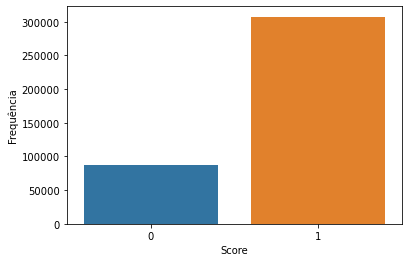

In [66]:
ax = sns.countplot(df['score2']) 
ax.set(xlabel='Score', ylabel='Frequência')
plt.show()

In [67]:
teste2 = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer()),
                     ('BNB', BernoulliNB())])
cv_pred = cross_validate(teste2,
                             df['text'], 
                             df['score2'], 
                             cv=5,
                             scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   34.5s remaining:   51.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   35.2s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.0s finished


In [68]:
print('roc: ' + str(cv_pred['test_roc_auc_ovr']))
print('acuracia: ' + str(cv_pred['test_accuracy']))

roc: [0.88104572 0.88162856 0.88156796 0.88091578 0.88397081]
acuracia: [0.83753895 0.83547415 0.83546148 0.833308   0.83694358]


### Regressão logistica

In [69]:
from sklearn.linear_model import LogisticRegression
teste3 = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer()),
                  ('logreg', LogisticRegression(max_iter = 1000))])

cv_pred = cross_validate(teste3,
                             df['text'], 
                             df['score2'], 
                             cv=5,
                             scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.3min remaining:   51.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


In [70]:
print('roc: ' + str(cv_pred['test_roc_auc_ovr']))
print('acuracia: ' + str(cv_pred['test_accuracy']))

roc: [0.92312948 0.92578911 0.92371525 0.92873604 0.92674591]
acuracia: [0.88414279 0.88458615 0.88519419 0.88646095 0.88784171]


In [36]:
result = teste3.fit(df['text'], df['score2'])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [41]:
teste3['logreg'].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [71]:
from sklearn.metrics import classification_report, confusion_matrix
result = teste2.fit(df['text'], df['score2'])
print(classification_report(df['score2'], result.predict(df['text'])))

              precision    recall  f1-score   support

           0       0.68      0.60      0.63     87100
           1       0.89      0.92      0.90    307610

    accuracy                           0.85    394710
   macro avg       0.78      0.76      0.77    394710
weighted avg       0.84      0.85      0.84    394710



In [73]:
confusion_matrix(df['score2'], result.predict(df['text']))

array([[51941, 35159],
       [ 7128, 79972]])

da pra ver que a acuracia da alta beleza. olhando p performace ali separadamente a gnt ve que grande parte do motivo da acuracia alta é o desbalanceamento, ai a gnt usa isso como justificativa pra fazer balanceado

## Procedimento com balanceamento dos dados usando downsampling

In [72]:
from sklearn.utils import resample

df1 = df[df.score2==0]
df2 = df[df.score2==1]
 
# Retirando uma amostra do tamanho da base amostra que tem o score = 0
df2_downsampled = resample(df2,
               replace = False,    
               n_samples=len(df1), 
               random_state=42) 
 
# Combine minority class with downsampled majority class
df = pd.concat([df1, df2_downsampled])
 
# Display new class counts
df.score2.value_counts()

1    87100
0    87100
Name: score2, dtype: int64

#### Divisão treino-teste

In [76]:
from sklearn.model_selection import train_test_split
X = df['text']
y = df['score2']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

360628    must slow cooker recipes throw pork tenderloin...
265365    grew eating buckwheat pancakes week breakfast ...
326434    cookies make great snack light treat instead d...
115210    love dark chocolate recently decided eat sugar...
511493    ramen better cheaper stuff get local grocery s...
                                ...                        
472089    bad cannot find locally grocery stores buying ...
288986    looking great jasmine tea probably tried brand...
307331    price right barely competitive w supermarket p...
187857    product worked miracles son got terrible gas p...
239786    great flour substitute use recipes sub wheat f...
Name: text, Length: 139360, dtype: object
360628    1
265365    1
326434    1
115210    1
511493    1
         ..
472089    1
288986    1
307331    1
187857    1
239786    1
Name: score2, Length: 139360, dtype: int64


In [77]:
pipeline_NB = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                        ('Tfidf', TfidfTransformer()),
                        ('BNB', BernoulliNB())])

pipeline_logreg = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                        ('Tfidf', TfidfTransformer()),
                        ('LREG', LogisticRegression(max_iter = 1000))])

# 5-fold cross-validation no treino para ambos os modelos
cv1 = cross_validate(pipeline_NB,
                     X_train, 
                     y_train, 
                     cv=5,
                     scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)

cv2 = cross_validate(pipeline_logreg,
                     X_train, 
                     y_train, 
                     cv = 5,
                     scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.3s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.2s remaining:   31.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.4s remaining:   14.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.4s finished


In [78]:
print("Resultados para o NB:")
print('roc: ' + str(cv1['test_roc_auc_ovr']))
print('acuracia: ' + str(cv1['test_accuracy']))

Resultados para o NB:
roc: [0.88228243 0.88211654 0.88631492 0.88365494 0.88508601]
acuracia: [0.78989667 0.79158295 0.79613949 0.78986079 0.79294633]


In [79]:
print("Resultados para a regressão logística:")
print('roc: ' + str(cv2['test_roc_auc_ovr']))
print('acuracia: ' + str(cv2['test_accuracy']))

Resultados para a regressão logística:
roc: [0.92203203 0.92062655 0.92211078 0.92489159 0.92168691]
acuracia: [0.84525689 0.84306831 0.84554392 0.8492035  0.84690729]


In [80]:
## ajuste do modelo e avaliação na base de treino
results1 = pipeline_NB.fit(X_train, y_train)
results2 = pipeline_logreg.fit(X_train, y_train)

### Performances no treino

In [81]:
print(classification_report(y_train, results1.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.75      0.81     69762
           1       0.78      0.89      0.83     69598

    accuracy                           0.82    139360
   macro avg       0.82      0.82      0.82    139360
weighted avg       0.82      0.82      0.82    139360



In [82]:
print(classification_report(y_train, results2.predict(X_train)))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87     69762
           1       0.87      0.87      0.87     69598

    accuracy                           0.87    139360
   macro avg       0.87      0.87      0.87    139360
weighted avg       0.87      0.87      0.87    139360



### Resultados no teste

In [88]:
print(classification_report(y_test, results1.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.843     0.726     0.780     17338
           1      0.761     0.866     0.810     17502

    accuracy                          0.796     34840
   macro avg      0.802     0.796     0.795     34840
weighted avg      0.802     0.796     0.795     34840



In [89]:
print(classification_report(y_test, results2.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.847     0.853     0.850     17338
           1      0.854     0.847     0.850     17502

    accuracy                          0.850     34840
   macro avg      0.850     0.850     0.850     34840
weighted avg      0.850     0.850     0.850     34840



 - matrizes de confusão

In [86]:
confusion_matrix(y_test, results1.predict(X_test))

array([[12588,  4750],
       [ 2341, 15161]])

In [87]:
confusion_matrix(y_test, results2.predict(X_test))

array([[14796,  2542],
       [ 2680, 14822]])

In [91]:
#curiosidade
#confusion_matrix(df2['score2'], results1.predict(df2['text']))

array([[     0,      0],
       [ 40287, 267323]])

In [105]:
#hmm = pipeline_logreg['Tfidf']
#hmm.fit_transform(CountVectorizer(stop_words='english').fit_transform(X_test[0]))
#print(len(df1))
#len(df2)
corpus = X_train

pipe = Pipeline([('count', CountVectorizer(stop_words = 'english')),
                 ('tfid', TfidfTransformer())]).fit(corpus)


In [112]:
print(pipe.transform(corpus)[0])
print(X_train[0])

  (0, 64503)	0.17819139532576303
  (0, 63837)	0.31408801857734747
  (0, 59790)	0.16957381877339403
  (0, 58870)	0.22566356809371627
  (0, 52917)	0.18793411139998406
  (0, 49967)	0.18345175279786946
  (0, 49810)	0.2142982788365569
  (0, 48026)	0.18206165471687913
  (0, 45715)	0.2134100436322883
  (0, 43341)	0.24800639738692415
  (0, 39879)	0.19463805166301912
  (0, 39336)	0.1465080008401595
  (0, 33036)	0.177387388296609
  (0, 21630)	0.189414182394608
  (0, 18649)	0.28683480394779803
  (0, 17697)	0.2552849536691848
  (0, 15251)	0.22534794387765616
  (0, 12007)	0.32324313619710904
  (0, 10193)	0.11096203553763313
  (0, 9791)	0.3051305180738013
bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better


In [117]:
vc = CountVectorizer(stop_words = 'english')
vect = vc.fit_transform(X_train[0:5])
vect

  (0, 114)	1
  (0, 29)	1
  (0, 106)	1
  (0, 128)	1
  (0, 95)	1
  (0, 126)	1
  (0, 16)	1
  (0, 35)	1
  (0, 96)	1
  (0, 24)	1
  (0, 87)	1
  (0, 92)	1
  (0, 7)	1
  (0, 82)	1
  (0, 117)	1
  (0, 75)	1
  (0, 64)	1
  (0, 8)	1
  (0, 76)	1
  (0, 41)	1
  (1, 59)	1
  (1, 46)	2
  (1, 17)	3
  (1, 90)	4
  (1, 132)	1
  :	:
  (4, 60)	1
  (4, 102)	2
  (4, 9)	1
  (4, 19)	1
  (4, 120)	1
  (4, 72)	1
  (4, 118)	1
  (4, 84)	2
  (4, 6)	1
  (4, 83)	1
  (4, 133)	1
  (4, 26)	1
  (4, 67)	1
  (4, 81)	1
  (4, 91)	1
  (4, 111)	1
  (4, 1)	1
  (4, 49)	1
  (4, 88)	1
  (4, 53)	1
  (4, 112)	1
  (4, 98)	1
  (4, 99)	1
  (4, 135)	1
  (4, 130)	1


# Abordagem com redes neurais (talvez)

pode ser meio overkill dado o que ja temos kkkk vai rolar nao mane, ja teve 85% de acuracia ali com os anteriores to suave hahahah

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.utils import to_categorical

In [ ]:
X = np.array(list(df['tfidf']))
len_treino = int(.8*X.shape[0])
inds = np.random.choice(range(X.shape[0]), len_treino, replace = False)

x_treino = X[inds].reshape((-1, 100, 1))
x_teste = X[inds].reshape((-1, 100, 1))
y_treino = to_categorical(np.array(df['score'])[inds])
y_teste = to_categorical(np.delete(np.array(df['score']), inds))

In [ ]:
model = Sequential()
model.add(SimpleRNN(128, input_shape = (X.shape[1],1), activation = 'sigmoid'))
model.add(Dense(1, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
## ainda n rolou
history = model.fit(x_treino, y_treino, epochs = 1, batch_size = 16) 